<a href="https://colab.research.google.com/github/Pestrdan/netology_research/blob/main/Deep_learning_(Pytorch)/DLL_35_HW10_%D0%9A%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 torchdata==0.5.1 torchtext==0.14.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 61.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0+cu121
    Uninstalling torch-2.3.0+cu121:
      Successfully uninstalled torch-2.3.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.0+cu121
    Uninstal

In [ ]:
%%shell

git clone https://github.com/Shenggan/BCCD_Dataset.git

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800
Receiving objects: 100% (800/800), 7.39 MiB | 37.45 MiB/s, done.
Resolving deltas: 100% (378/378), done.


In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import pandas as pd
from PIL import Image, ImageDraw
import torchvision as tv

In [ ]:
#torch.multiprocessing.set_start_method('spawn')

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

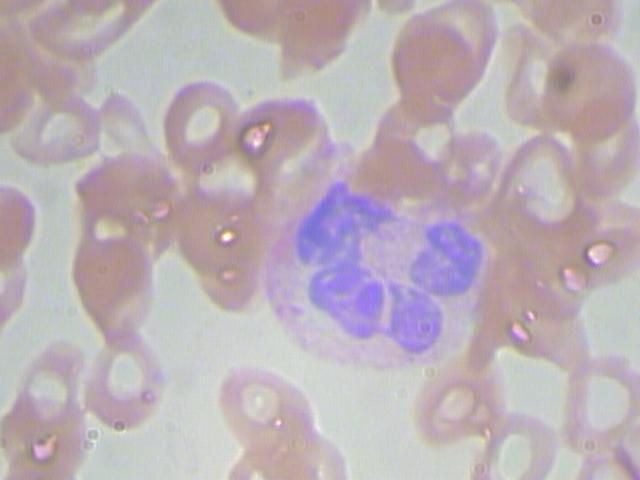

In [ ]:
from PIL import Image
Image.open('BCCD_Dataset/BCCD/JPEGImages/BloodImage_00000.jpg')

In [ ]:
class BCCDDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms
    self.pds = pd.read_csv(os.path.join(root,"test.csv"))
    self.imgs = list(sorted(os.listdir(os.path.join(root, "BCCD/JPEGImages"))))
    self.classes = ['Background'] + list(self.pds.cell_type.unique())
    self.classes_idx = {w: i for i, w in enumerate(self.classes)}

  #def get_image(self, idx):
    #filename = self.imgs[idx]
    #img = Image.open(os.path.join(self.root+'BCCD/JPEGImages',filename)).convert("RGB")
    #return img

  def __getitem__(self, idx):
    img_path = os.path.join(self.root, "BCCD/JPEGImages", self.imgs[idx])
    img = Image.open(img_path).convert("RGB")

    filename = self.imgs[idx]
    x = self.pds
    x = x[x.filename == filename]
    x = x[x.xmin < x.xmax]
    x = x[x.ymin < x.ymax]
    x = np.array(x)
    for i in range(len(x)):
      x[i,1]=self.classes_idx[x[i,1]]
    labels  = torch.as_tensor(x[:,1].astype(int), dtype=torch.int64).to(device)
    boxes = torch.as_tensor(x[:,[2,4,3,5]].astype(float), dtype=torch.float32).to(device)

    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
    iscrowd = torch.zeros((len(x),), dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    #target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target
  def __len__(self):
    return len(self.imgs)

In [ ]:
ds = BCCDDataset('BCCD_Dataset/')
ds[0]

(<PIL.Image.Image image mode=RGB size=640x480>,
 {'boxes': tensor([[260., 177., 491., 376.],
          [ 78., 336., 184., 435.],
          [ 63., 237., 169., 336.],
          [214., 362., 320., 461.],
          [414., 352., 506., 445.],
          [555., 356., 640., 455.],
          [469., 412., 567., 480.],
          [  1., 333.,  87., 437.],
          [  4., 406.,  95., 480.],
          [155.,  74., 247., 174.],
          [ 11.,  84., 104., 162.],
          [534.,  39., 639., 139.],
          [547., 195., 640., 295.],
          [388.,  11., 481., 111.],
          [171., 175., 264., 275.],
          [260.,   1., 374.,  83.],
          [229.,  91., 343., 174.],
          [ 69., 144., 184., 235.],
          [482., 131., 594., 230.],
          [368.,  89., 464., 176.]], device='cuda:0'),
  'labels': tensor([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
         device='cuda:0'),
  'image_id': tensor([0]),
  'area': tensor([45969., 10494., 10494., 10494.,  8556.,  8415.,  66

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 531480, done.
remote: Counting objects: 100% (45090/45090), done.
remote: Compressing objects: 100% (2112/2112), done.
remote: Total 531480 (delta 43044), reused 44882 (delta 42905), pack-reused 486390
Receiving objects: 100% (531480/531480), 1022.60 MiB | 51.29 MiB/s, done.
Resolving deltas: 100% (496279/496279), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = BCCDDataset('BCCD_Dataset/', get_transform(train=True))
dataset_test = BCCDDataset('BCCD_Dataset/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [ ]:
dataset_test[2]

(tensor([[[0.7059, 0.7020, 0.7020,  ..., 0.7608, 0.7608, 0.7569],
          [0.7059, 0.7020, 0.7020,  ..., 0.7647, 0.7608, 0.7608],
          [0.7098, 0.7059, 0.7059,  ..., 0.7647, 0.7647, 0.7608],
          ...,
          [0.7725, 0.7608, 0.7569,  ..., 0.7765, 0.7765, 0.7686],
          [0.7608, 0.7490, 0.7451,  ..., 0.7843, 0.7804, 0.7765],
          [0.7529, 0.7412, 0.7373,  ..., 0.7882, 0.7843, 0.7765]],
 
         [[0.7490, 0.7451, 0.7451,  ..., 0.7843, 0.7843, 0.7804],
          [0.7490, 0.7451, 0.7451,  ..., 0.7882, 0.7843, 0.7843],
          [0.7451, 0.7412, 0.7412,  ..., 0.7882, 0.7882, 0.7843],
          ...,
          [0.7922, 0.7804, 0.7647,  ..., 0.7529, 0.7451, 0.7412],
          [0.7804, 0.7686, 0.7529,  ..., 0.7529, 0.7412, 0.7373],
          [0.7725, 0.7608, 0.7451,  ..., 0.7569, 0.7451, 0.7373]],
 
         [[0.7255, 0.7216, 0.7216,  ..., 0.7765, 0.7765, 0.7725],
          [0.7255, 0.7216, 0.7216,  ..., 0.7804, 0.7765, 0.7765],
          [0.7255, 0.7216, 0.7216,  ...,

In [ ]:
df = pd.read_csv('BCCD_Dataset/test.csv')

In [ ]:
n_classes = len(list(df.cell_type.unique())) + 1 # уникальные классы + background

In [ ]:
from torchvision import models
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [ ]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()

Epoch: [0]  [  0/157]  eta: 0:02:43  lr: 0.000037  loss: 2.6272 (2.6272)  loss_classifier: 1.3803 (1.3803)  loss_box_reg: 0.6887 (0.6887)  loss_objectness: 0.4624 (0.4624)  loss_rpn_box_reg: 0.0958 (0.0958)  time: 1.0395  data: 0.0136  max mem: 676
Epoch: [0]  [ 10/157]  eta: 0:00:28  lr: 0.000357  loss: 2.2427 (2.2714)  loss_classifier: 1.1477 (1.1857)  loss_box_reg: 0.8408 (0.7622)  loss_objectness: 0.1655 (0.2647)  loss_rpn_box_reg: 0.0528 (0.0588)  time: 0.1969  data: 0.0110  max mem: 816
Epoch: [0]  [ 20/157]  eta: 0:00:21  lr: 0.000677  loss: 1.8153 (1.9444)  loss_classifier: 0.8070 (0.9330)  loss_box_reg: 0.8116 (0.7511)  loss_objectness: 0.1457 (0.2092)  loss_rpn_box_reg: 0.0426 (0.0512)  time: 0.1109  data: 0.0107  max mem: 816
Epoch: [0]  [ 30/157]  eta: 0:00:17  lr: 0.000998  loss: 1.4235 (1.7424)  loss_classifier: 0.5453 (0.7949)  loss_box_reg: 0.7551 (0.7229)  loss_objectness: 0.0915 (0.1738)  loss_rpn_box_reg: 0.0425 (0.0509)  time: 0.1088  data: 0.0105  max mem: 816
Epoc

In [ ]:
dataset_test[0]

(tensor([[[0.6314, 0.6353, 0.6314,  ..., 0.6941, 0.6902, 0.6902],
          [0.6353, 0.6392, 0.6353,  ..., 0.6941, 0.6902, 0.6902],
          [0.6275, 0.6353, 0.6471,  ..., 0.6941, 0.6902, 0.6902],
          ...,
          [0.6902, 0.6902, 0.6824,  ..., 0.7098, 0.7098, 0.7059],
          [0.6902, 0.6902, 0.6824,  ..., 0.7137, 0.7098, 0.7059],
          [0.6902, 0.6902, 0.6824,  ..., 0.7137, 0.7059, 0.7059]],
 
         [[0.5686, 0.5725, 0.5804,  ..., 0.6039, 0.6000, 0.6000],
          [0.5725, 0.5765, 0.5843,  ..., 0.6039, 0.6000, 0.6000],
          [0.5765, 0.5882, 0.6000,  ..., 0.6039, 0.6000, 0.6000],
          ...,
          [0.5961, 0.5961, 0.5961,  ..., 0.6000, 0.6000, 0.5961],
          [0.5961, 0.5961, 0.5961,  ..., 0.6039, 0.6000, 0.5961],
          [0.5961, 0.5961, 0.5961,  ..., 0.6039, 0.5961, 0.5961]],
 
         [[0.6118, 0.6118, 0.6157,  ..., 0.6667, 0.6627, 0.6627],
          [0.6118, 0.6157, 0.6118,  ..., 0.6667, 0.6627, 0.6627],
          [0.6039, 0.6039, 0.6078,  ...,

In [ ]:
dataset_test[0]

(tensor([[[0.6314, 0.6353, 0.6314,  ..., 0.6941, 0.6902, 0.6902],
          [0.6353, 0.6392, 0.6353,  ..., 0.6941, 0.6902, 0.6902],
          [0.6275, 0.6353, 0.6471,  ..., 0.6941, 0.6902, 0.6902],
          ...,
          [0.6902, 0.6902, 0.6824,  ..., 0.7098, 0.7098, 0.7059],
          [0.6902, 0.6902, 0.6824,  ..., 0.7137, 0.7098, 0.7059],
          [0.6902, 0.6902, 0.6824,  ..., 0.7137, 0.7059, 0.7059]],
 
         [[0.5686, 0.5725, 0.5804,  ..., 0.6039, 0.6000, 0.6000],
          [0.5725, 0.5765, 0.5843,  ..., 0.6039, 0.6000, 0.6000],
          [0.5765, 0.5882, 0.6000,  ..., 0.6039, 0.6000, 0.6000],
          ...,
          [0.5961, 0.5961, 0.5961,  ..., 0.6000, 0.6000, 0.5961],
          [0.5961, 0.5961, 0.5961,  ..., 0.6039, 0.6000, 0.5961],
          [0.5961, 0.5961, 0.5961,  ..., 0.6039, 0.5961, 0.5961]],
 
         [[0.6118, 0.6118, 0.6157,  ..., 0.6667, 0.6627, 0.6627],
          [0.6118, 0.6157, 0.6118,  ..., 0.6667, 0.6627, 0.6627],
          [0.6039, 0.6039, 0.6078,  ...,

In [ ]:
imgs = list(sorted(set(df['filename'])))

In [ ]:
imgs[151]

'BloodImage_00176.jpg'

In [ ]:
import matplotlib.pyplot as plt

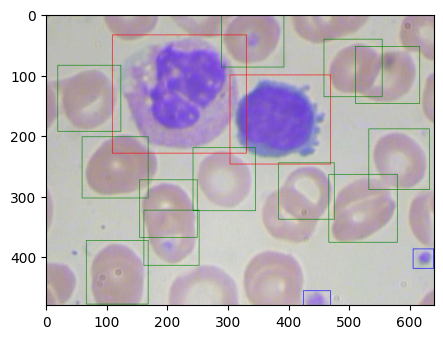

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    outputs = model([img.to(device)])
    img = Image.open('BCCD_Dataset/BCCD/JPEGImages/BloodImage_00176.jpg')
    draw = ImageDraw.Draw(img)
    classes = outputs[0]['labels'].cpu().numpy()
    scores = outputs[0]['scores'].detach().cpu().numpy()
    boxes = outputs[0]['boxes'].detach().cpu().numpy()

    for i,box in enumerate(boxes):
       if scores[i] > 0.5 :
        c = classes[i]
        c = c if c < 4 else 0
        cl = ['black','red','green','blue']
        draw.rectangle(xy=box.tolist(), outline=cl[c])
    plt.figure(figsize=(5, 5))
    plt.imshow(img)

In [ ]:
dataset_test[5]

(tensor([[[0.6471, 0.6510, 0.6510,  ..., 0.7451, 0.7373, 0.7294],
          [0.6471, 0.6510, 0.6510,  ..., 0.7412, 0.7333, 0.7255],
          [0.6471, 0.6510, 0.6549,  ..., 0.7412, 0.7333, 0.7294],
          ...,
          [0.7725, 0.7725, 0.7725,  ..., 0.6941, 0.7020, 0.7137],
          [0.7686, 0.7686, 0.7686,  ..., 0.6863, 0.6941, 0.7020],
          [0.7647, 0.7647, 0.7647,  ..., 0.6824, 0.6902, 0.6980]],
 
         [[0.5529, 0.5569, 0.5569,  ..., 0.6941, 0.6863, 0.6784],
          [0.5529, 0.5569, 0.5569,  ..., 0.6902, 0.6824, 0.6745],
          [0.5529, 0.5608, 0.5647,  ..., 0.6784, 0.6706, 0.6667],
          ...,
          [0.7804, 0.7804, 0.7804,  ..., 0.5961, 0.6039, 0.6157],
          [0.7765, 0.7765, 0.7765,  ..., 0.5843, 0.5961, 0.6039],
          [0.7725, 0.7725, 0.7725,  ..., 0.5804, 0.5922, 0.6000]],
 
         [[0.6078, 0.6118, 0.6078,  ..., 0.7294, 0.7216, 0.7137],
          [0.6078, 0.6078, 0.6078,  ..., 0.7255, 0.7176, 0.7098],
          [0.6039, 0.6000, 0.6039,  ...,

In [ ]:
imgs[153]

'BloodImage_00178.jpg'

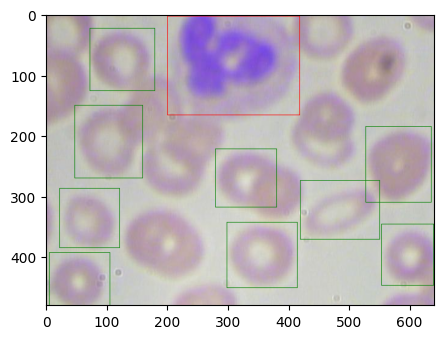

In [ ]:
# pick one image from the test set
img, _ = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    outputs = model([img.to(device)])
    img = Image.open('BCCD_Dataset/BCCD/JPEGImages/BloodImage_00178.jpg')
    draw = ImageDraw.Draw(img)
    classes = outputs[0]['labels'].cpu().numpy()
    scores = outputs[0]['scores'].detach().cpu().numpy()
    boxes = outputs[0]['boxes'].detach().cpu().numpy()

    for i,box in enumerate(boxes):
       if scores[i] > 0.5 :
        c = classes[i]
        c = c if c < 4 else 0
        cl = ['black','red','green','blue']
        draw.rectangle(xy=box.tolist(), outline=cl[c])
    plt.figure(figsize=(5, 5))
    plt.imshow(img)